In [1]:
!pip install biopython pandas requests tqdm transformers 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 31.1 MB/s eta 0:00:0000:0100:01


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import os
import pandas as pd
import requests
from tqdm import tqdm
from Bio import SeqIO
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTENC
from transformers import AutoTokenizer, AutoModel
import torch

In [3]:
!git clone --depth 1 https://github.com/mstrazar/iONMF.git /kaggle/working/iONMF_dataset


Cloning into '/kaggle/working/iONMF_dataset'...
remote: Enumerating objects: 649, done.
remote: Counting objects: 100% (649/649), done.
remote: Compressing objects: 100% (534/534), done.
remote: Total 649 (delta 82), reused 639 (delta 80), pack-reused 0 (from 0)
Receiving objects: 100% (649/649), 57.07 MiB | 40.30 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
base_path = "/kaggle/working/iONMF_dataset/datasets/clip/"

In [5]:
selected_folders = [
    "5_CLIPSEQ_AGO2_hg19",
    "8_PARCLIP_ELAVL1_hg19",
    "10_PARCLIP_ELAVL1A_hg19",
    "12_PARCLIP_EWSR1_hg19",
    "14_PARCLIP_FUS_mut_hg19",
    "15_PARCLIP_IGF2BP123_hg19",
    "17_ICLIP_HNRNPC_hg19",
    "19_ICLIP_hnRNPL_U266",
    "21_PARCLIP_MOV10_Sievers_hg19",
    "23_PARCLIP_PUM2_hg19",
    "27_ICLIP_TDP43_hg19"
]

In [6]:
positions_list = []
rnafold_list = []
region_list = []
cobinding_list = []
sequences_list = []
response_list = []

In [7]:
for folder in selected_folders:
    for sample in ["training_sample_0", "test_sample_0"]:  
        dataset_path = os.path.join(base_path, folder, "5000", sample)  

        #positions 
        pos_file = os.path.join(dataset_path, "positions.bedGraph.gz")
        if os.path.exists(pos_file):
            positions_list.append(pd.read_csv(pos_file, sep="\t", names=["chromosome", "start", "end", "binding_score"]))

        #RNAfold features
        rnafold_file = os.path.join(dataset_path, "matrix_RNAfold.tab.gz")
        if os.path.exists(rnafold_file):
            rnafold_list.append(pd.read_csv(rnafold_file, sep="\t", compression="gzip"))

        #genomic region annotations
        region_file = os.path.join(dataset_path, "matrix_RegionType.tab.gz")
        if os.path.exists(region_file):
            region_list.append(pd.read_csv(region_file, sep="\t", compression="gzip"))

        #co-binding features
        cobinding_file = os.path.join(dataset_path, "matrix_Cobinding.tab.gz")
        if os.path.exists(cobinding_file):
            cobinding_list.append(pd.read_csv(cobinding_file, sep="\t", compression="gzip"))

        #sequences
        sequences_file = os.path.join(dataset_path, "sequences.fa.gz")
        if os.path.exists(sequences_file):
            sequences_list.append(pd.read_csv(sequences_file, sep="\t", compression="gzip", names=["sequence"]))

        #response labels
        response_file = os.path.join(dataset_path, "matrix_Response.tab.gz")
        if os.path.exists(response_file):
            response_list.append(pd.read_csv(response_file, sep="\t", compression="gzip", names=["response_label"]))


In [8]:
print(f"Positions files loaded: {len(positions_list)}")
print(f"RNAfold files loaded: {len(rnafold_list)}")
print(f"RegionType files loaded: {len(region_list)}")
print(f"Cobinding files loaded: {len(cobinding_list)}")
print(f"Sequences files loaded: {len(sequences_list)}")
print(f"Response labels loaded: {len(response_list)}")

Positions files loaded: 20
RNAfold files loaded: 20
RegionType files loaded: 20
Cobinding files loaded: 20
Sequences files loaded: 20
Response labels loaded: 20


In [9]:
#merge data 
positions_df = pd.concat(positions_list, ignore_index=True) if positions_list else None
rnafold_df = pd.concat(rnafold_list, ignore_index=True) if rnafold_list else None
region_df = pd.concat(region_list, ignore_index=True) if region_list else None
cobinding_df = pd.concat(cobinding_list, ignore_index=True) if cobinding_list else None
sequences_df = pd.concat(sequences_list, ignore_index=True) if sequences_list else None
response_df = pd.concat(response_list, ignore_index=True) if response_list else None


In [10]:
print(f"Positions Data Shape: {positions_df.shape}")
print(f"RNAfold Data Shape: {rnafold_df.shape}")
print(f"RegionType Data Shape: {region_df.shape}")
print(f"Cobinding Data Shape: {cobinding_df.shape}")
print(f"Sequences Data Shape: {sequences_df.shape}")
print(f"Response Labels Shape: {response_df.shape}")


Positions Data Shape: (60020, 4)
RNAfold Data Shape: (60000, 101)
RegionType Data Shape: (60000, 505)
Cobinding Data Shape: (60000, 3131)
Sequences Data Shape: (180000, 1)
Response Labels Shape: (60020, 1)


In [11]:
merged_df = positions_df.merge(response_df, left_index=True, right_index=True)  
merged_df = merged_df.merge(rnafold_df, left_index=True, right_index=True)  
merged_df = merged_df.merge(region_df, left_index=True, right_index=True)  
merged_df = merged_df.merge(cobinding_df, left_index=True, right_index=True)  
merged_df = merged_df.merge(sequences_df, left_index=True, right_index=True)  


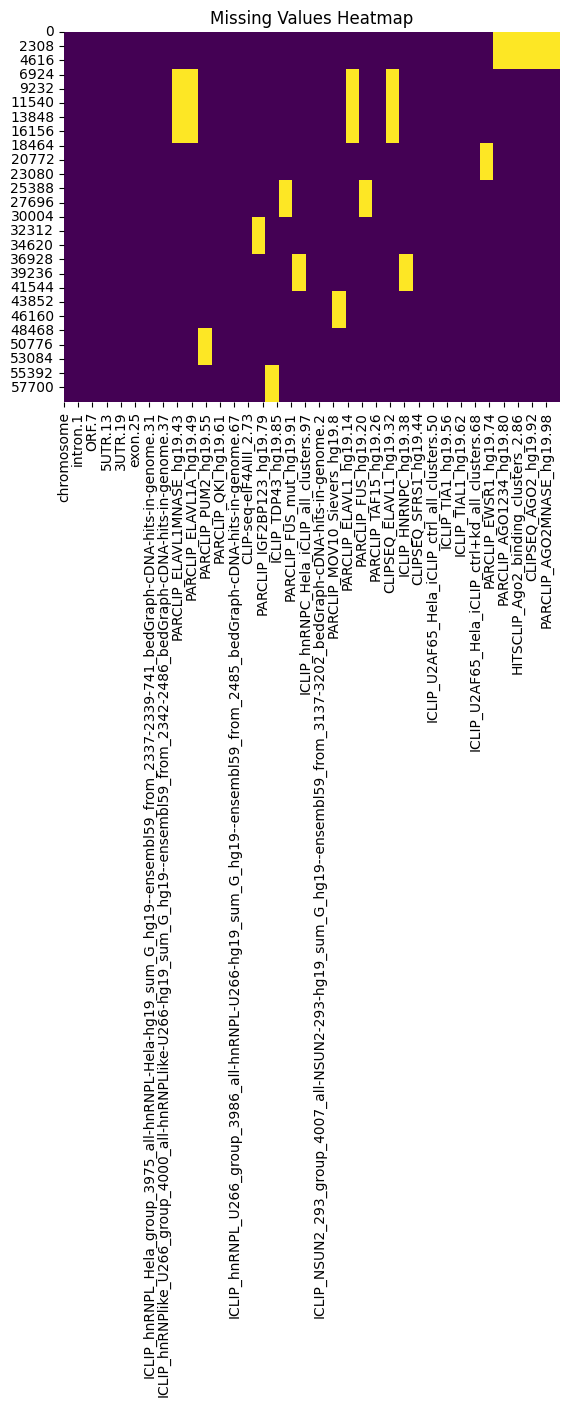

In [12]:
sns.heatmap(merged_df.isnull(), cmap="viridis", cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

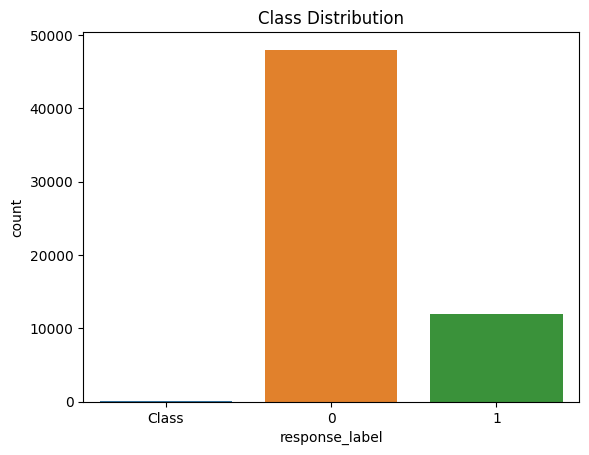

response_label
0        0.799717
1        0.199950
Class    0.000333
Name: proportion, dtype: float64


In [13]:
sns.countplot(x="response_label", data=merged_df)
plt.title("Class Distribution")
plt.show()

print(merged_df["response_label"].value_counts(normalize=True))

In [12]:
print(merged_df.dtypes.value_counts())

float64    1922
int64      1818
object        3
Name: count, dtype: int64


In [12]:
num_cols = merged_df.select_dtypes(include=['number']).columns
merged_df[num_cols] = merged_df[num_cols].fillna(merged_df[num_cols].median())

In [13]:
cat_cols = merged_df.select_dtypes(include=['object']).columns
merged_df[cat_cols] = merged_df[cat_cols].fillna(merged_df[cat_cols].mode().iloc[0])

In [14]:
print("Categorical Columns:", cat_cols)

Categorical Columns: Index(['chromosome', 'response_label', 'sequence'], dtype='object')


In [15]:
cat_cols = merged_df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove("response_label")
cat_cols.remove("sequence")
# ne hot encoding only to cat features
merged_df = pd.get_dummies(merged_df, columns=cat_cols, drop_first=True)

In [16]:
imbalance_ratio = merged_df["response_label"].value_counts(normalize=True)
print(imbalance_ratio)

response_label
0        0.799717
1        0.199950
Class    0.000333
Name: proportion, dtype: float64


In [17]:
print(merged_df.shape)
print(merged_df.head())
print(merged_df.dtypes.value_counts())  

(60000, 3767)
        start         end  binding_score response_label     dsRNA   dsRNA.1  \
0  62504223.0  62504224.0            0.0          Class  0.823529  1.000000   
1    949631.0    949632.0            0.0              0  0.769231  0.692308   
2   1511321.0   1511322.0            0.0              0  0.000000  0.000000   
3   1568143.0   1568144.0            0.0              0  0.087500  0.087500   
4   2521266.0   2521267.0            0.0              0  0.000000  0.000000   

    dsRNA.2   dsRNA.3   dsRNA.4   dsRNA.5  ...  chromosome_chr4  \
0  0.647059  1.000000  1.000000  0.294118  ...            False   
1  0.846154  0.692308  0.769231  0.615385  ...            False   
2  0.000000  0.000000  0.200000  0.400000  ...            False   
3  0.125000  0.075000  0.075000  0.037500  ...            False   
4  0.000000  0.000000  0.000000  0.000000  ...            False   

   chromosome_chr5  chromosome_chr6  chromosome_chr7  chromosome_chr8  \
0            False            False

In [18]:
from transformers import BertTokenizer

In [19]:
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

In [20]:
def tokenize_rna(sequence):
    return tokenizer(sequence, padding="max_length", truncation=True, return_tensors="pt")

In [21]:
# tokenization to the RNA sequences
merged_df["tokenized_sequence"] = merged_df["sequence"].apply(lambda x: tokenize_rna(x))

In [22]:
#remove non numeric values and convert to int
merged_df = merged_df[merged_df["response_label"] != "Class"]  
merged_df["response_label"] = merged_df["response_label"].astype(int)

In [23]:
print(merged_df["response_label"].unique())

[0 1]


In [24]:
from sklearn.preprocessing import StandardScaler
import torch

In [25]:
tabular_features = merged_df.drop(columns=["sequence", "tokenized_sequence", "response_label"])

In [26]:
#normalize numerical features
scaler = StandardScaler()
tabular_features = scaler.fit_transform(tabular_features)

In [27]:
# convert to tensor
tabular_features_tensor = torch.tensor(tabular_features, dtype=torch.float32)

In [28]:
print(tabular_features_tensor.shape)

torch.Size([59980, 3765])


In [29]:
response_labels_tensor = torch.tensor(merged_df["response_label"].values, dtype=torch.float32)

In [30]:
print(response_labels_tensor.shape) 

torch.Size([59980])


In [31]:
# extract input_ids and convert to tensors
input_ids_list = [x["input_ids"].squeeze(0) for x in merged_df["tokenized_sequence"]]
input_ids_tensor = torch.stack(input_ids_list)

In [32]:
print(input_ids_tensor.shape)

torch.Size([59980, 512])


In [33]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [34]:
class RNAMultimodalDataset(Dataset):
    def __init__(self, input_ids, tabular_data, labels):
        self.input_ids = input_ids
        self.tabular_data = tabular_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.tabular_data[idx], self.labels[idx]

In [35]:
dataset = RNAMultimodalDataset(input_ids_tensor, tabular_features_tensor, response_labels_tensor)

In [36]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [41]:
batch = next(iter(dataloader))
input_ids_batch, tabular_batch, label_batch = batch

In [42]:
print(input_ids_batch.shape)  
print(tabular_batch.shape)  
print(label_batch.shape)

torch.Size([32, 512])
torch.Size([32, 3765])
torch.Size([32])


In [37]:
import torch.nn as nn
from transformers import BertModel

In [50]:
class MultimodalRNAInteractionModel(nn.Module):
    def __init__(self, tabular_input_dim, hidden_dim=256):
        super(MultimodalRNAInteractionModel, self).__init__()

        self.bio_bert = BertModel.from_pretrained("dmis-lab/biobert-v1.1")

        # MLP
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )

        # learned weights
        self.fusion = nn.Linear(768 + hidden_dim // 2, 1)  # 768 = BERT CLS size

        # final output
        self.output = nn.Linear(768 + hidden_dim // 2, 1)

    def forward(self, input_ids, tabular_features):
        # sequence encoding with CLS token from BioBERT
        bert_out = self.bio_bert(input_ids=input_ids, attention_mask=(input_ids != 0))
        cls_embedding = bert_out.last_hidden_state[:, 0, :]  

        # tabular encoding
        tabular_out = self.tabular_net(tabular_features)

        combined = torch.cat((cls_embedding, tabular_out), dim=1)
        
        fusion_weights = torch.sigmoid(self.fusion(combined))
        fused = fusion_weights * combined

        # final prediction
        output = self.output(fused).squeeze(1)
        return output

In [78]:
# stratified indices
train_idx, val_idx = train_test_split(
    np.arange(len(merged_df)),
    test_size=0.2,
    stratify=merged_df["response_label"],
    random_state=42
)

In [79]:
# tensor indexing to split data
train_dataset = RNAMultimodalDataset(
    input_ids_tensor[train_idx],
    tabular_features_tensor[train_idx],
    response_labels_tensor[train_idx]
)

In [80]:
val_dataset = RNAMultimodalDataset(
    input_ids_tensor[val_idx],
    tabular_features_tensor[val_idx],
    response_labels_tensor[val_idx]
)

In [81]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [67]:
model.to(device)

DataParallel(
  (module): MultimodalRNAInteractionModel(
    (bio_bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

In [68]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [73]:
epochs = 3
model.train()

DataParallel(
  (module): MultimodalRNAInteractionModel(
    (bio_bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

In [74]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    total_train_loss = 0.0
    total_val_loss = 0.0
    correct_train, correct_val = 0, 0
    total_train, total_val = 0, 0

    model.train()
    for input_ids, tabular_data, labels in train_loader:
        input_ids = input_ids.to(device)
        tabular_data = tabular_data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, tabular_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / total_train

    model.eval()
    with torch.no_grad():
        for input_ids, tabular_data, labels in val_loader:
            input_ids = input_ids.to(device)
            tabular_data = tabular_data.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, tabular_data)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / total_val

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_acc:.4f}")


Epoch 1/3 - Train Loss: 0.1030 - Train Acc: 0.9897 - Val Loss: 0.1099 - Val Acc: 0.9879
Epoch 2/3 - Train Loss: 0.0900 - Train Acc: 0.9926 - Val Loss: 0.1112 - Val Acc: 0.9860
Epoch 3/3 - Train Loss: 0.0819 - Train Acc: 0.9930 - Val Loss: 0.1112 - Val Acc: 0.9852


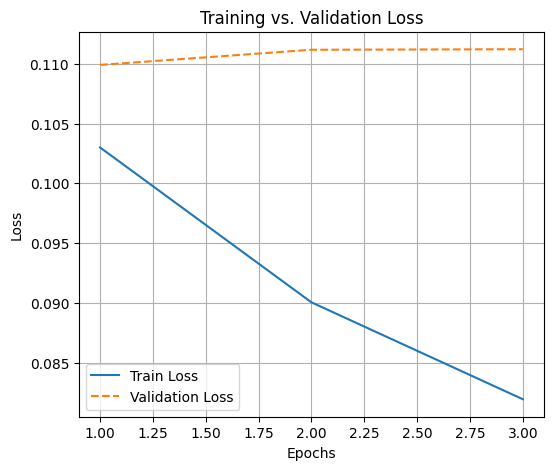

In [75]:
plt.figure(figsize=(6,5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid()
plt.show()

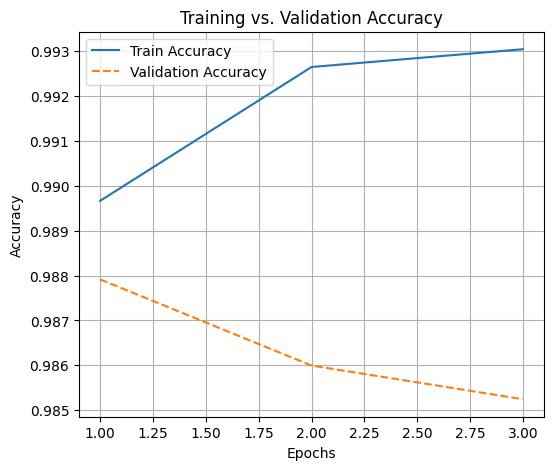

In [76]:
plt.figure(figsize=(6,5))
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

In [46]:
model = MultimodalRNAInteractionModel(tabular_input_dim=3765)  


from transformers import BertModel
model.bio_bert = BertModel.from_pretrained("dmis-lab/biobert-v1.1")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [47]:
model_path = "/kaggle/input/multimodal-biobert-weights/pytorch/default/1/multimodal_model_weights.pth"
model.load_state_dict(torch.load(model_path))

<ipython-input-47-cbd6ce24f44c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [48]:
model = MultimodalRNAInteractionModel(tabular_input_dim=tabular_features_tensor.shape[1])

In [52]:
# unfreeze top BioBERT layers
for name, param in model.bio_bert.named_parameters():
    if any(layer in name for layer in ["encoder.layer.8", "encoder.layer.9", "encoder.layer.10", "encoder.layer.11", "pooler"]):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [53]:
all_indices = np.arange(len(merged_df))

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
# first split 70-30
train_idx, temp_idx = train_test_split(
    all_indices,
    test_size=0.3,
    stratify=merged_df["response_label"],
    random_state=42
)

In [56]:
# second split 15 val 15 test from the 30
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=merged_df["response_label"].iloc[temp_idx],
    random_state=42
)

In [57]:
train_dataset = RNAMultimodalDataset(
    input_ids_tensor[train_idx],
    tabular_features_tensor[train_idx],
    response_labels_tensor[train_idx]
)

In [58]:
val_dataset = RNAMultimodalDataset(
    input_ids_tensor[val_idx],
    tabular_features_tensor[val_idx],
    response_labels_tensor[val_idx]
)

In [59]:
test_dataset = RNAMultimodalDataset(
    input_ids_tensor[test_idx],
    tabular_features_tensor[test_idx],
    response_labels_tensor[test_idx]
)

In [60]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [61]:
bert_params = []
other_params = []

In [62]:
for name, param in model.named_parameters():
    if param.requires_grad:
        if "bio_bert" in name:
            bert_params.append(param)
        else:
            other_params.append(param)

In [63]:
optimizer = torch.optim.Adam([
    {"params": bert_params, "lr": 1e-5},
    {"params": other_params, "lr": 1e-4}
])

In [64]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [65]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [66]:
criterion = torch.nn.BCEWithLogitsLoss()
epochs = 3

In [68]:
model.to(device)

MultimodalRNAInteractionModel(
  (bio_bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), ep

In [70]:
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [71]:
for epoch in range(epochs):
    total_train_loss, total_val_loss = 0.0, 0.0
    correct_train, correct_val = 0, 0
    total_train, total_val = 0, 0

    model.train()
    for input_ids, tabular_data, labels in train_loader:
        input_ids, tabular_data, labels = input_ids.to(device), tabular_data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, tabular_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation 
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for input_ids, tabular_data, labels in val_loader:
            input_ids, tabular_data, labels = input_ids.to(device), tabular_data.to(device), labels.to(device)

            outputs = model(input_ids, tabular_data)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_auc = roc_auc_score(all_labels, all_probs)
    val_f1 = f1_score(all_labels, all_preds)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | AUC: {val_auc:.4f} | F1: {val_f1:.4f}")

Epoch 1/3 | Train Loss: 0.5017 | Train Acc: 0.8000 | Val Loss: 0.5028 | Val Acc: 0.7999 | AUC: 0.5652 | F1: 0.0000
Epoch 2/3 | Train Loss: 0.3809 | Train Acc: 0.8440 | Val Loss: 0.1473 | Val Acc: 0.9549 | AUC: 0.9808 | F1: 0.8761
Epoch 3/3 | Train Loss: 0.0895 | Train Acc: 0.9683 | Val Loss: 0.0826 | Val Acc: 0.9681 | AUC: 0.9918 | F1: 0.9144


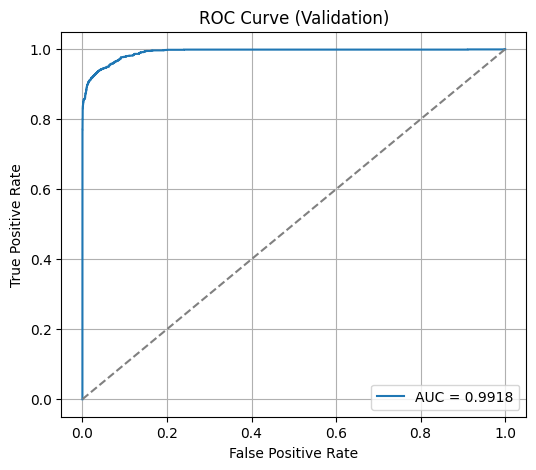

In [72]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {val_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.grid(True)
plt.show()

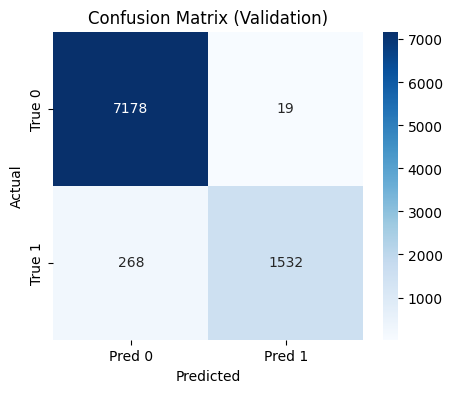

In [73]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation)")
plt.show()

In [74]:
torch.save(model.state_dict(), "fine_tuned_model.pth")

In [75]:
model.eval()

DataParallel(
  (module): MultimodalRNAInteractionModel(
    (bio_bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

In [76]:
all_test_labels, all_test_preds, all_test_probs = [], [], []

In [77]:
with torch.no_grad():
    for input_ids, tabular_data, labels in test_loader:
        input_ids = input_ids.to(device)
        tabular_data = tabular_data.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, tabular_data)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_test_labels.extend(labels.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())
        all_test_preds.extend(preds.cpu().numpy())


In [78]:
# convert to arrays
y_test = np.array(all_test_labels)
y_pred = np.array(all_test_preds)
y_prob = np.array(all_test_probs)

In [79]:
test_acc = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob)
test_f1 = f1_score(y_test, y_pred)

In [80]:
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test ROC AUC:  {test_auc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.9721
Test ROC AUC:  0.9926
Test F1 Score: 0.9255


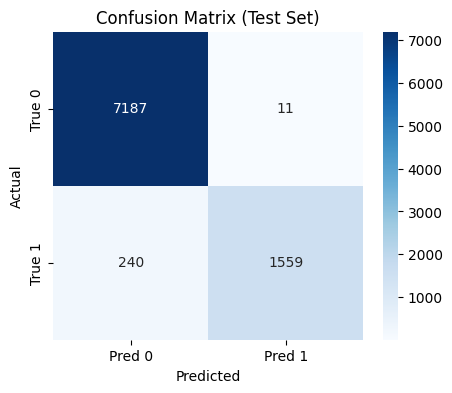

In [81]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()

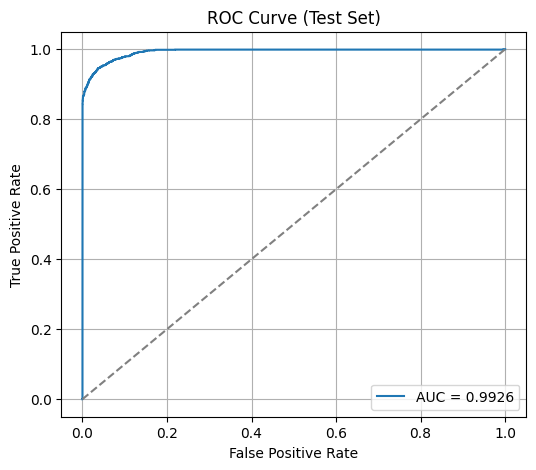

In [82]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


In [99]:
def model_predict(tabular_numpy):
    tab_tensor = torch.tensor(tabular_numpy, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = tabular_only_model(tab_tensor)
        probs = torch.sigmoid(logits).cpu().numpy()
    return probs

In [84]:
import shap

In [101]:
shap_values = explainer.shap_values(to_explain[:5].cpu().numpy())  # small batch first

  0%|          | 0/5 [00:00<?, ?it/s]

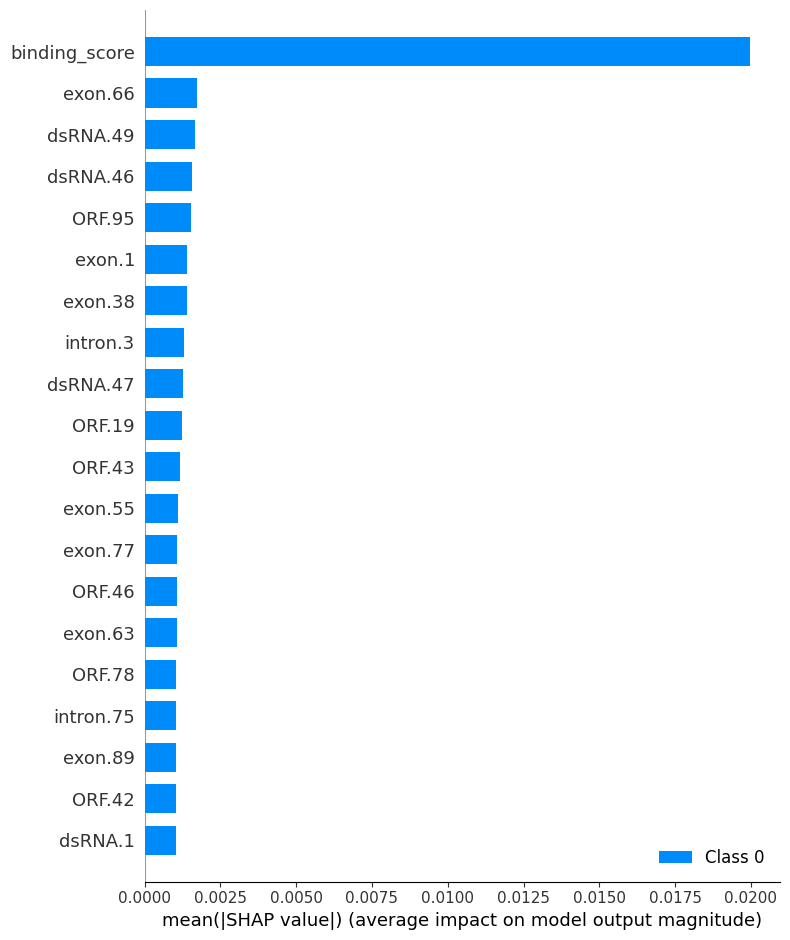

In [102]:
shap.summary_plot(
    shap_values,
    to_explain[:5].cpu().numpy(),
    feature_names=merged_df.drop(columns=["sequence", "response_label"]).columns.tolist()
)

In [104]:
cls_embeddings = []

full_dataset = RNAMultimodalDataset(
    input_ids_tensor,
    tabular_features_tensor,
    response_labels_tensor
)

In [106]:
model.eval()
with torch.no_grad():
    for input_ids, _, _ in DataLoader(full_dataset, batch_size=32):
        input_ids = input_ids.to(device)
        attention_mask = (input_ids != 0).long()
        bert_out = model.module.bio_bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = bert_out.last_hidden_state[:, 0, :]  # CLS token
        cls_embeddings.append(cls_emb.cpu())

cls_embeddings = torch.cat(cls_embeddings, dim=0).numpy()

In [108]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00


In [109]:
import umap.umap_ as umap

In [110]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
umap_proj = reducer.fit_transform(cls_embeddings)

In [111]:
# Use true labels
labels = merged_df["response_label"].astype(int).values

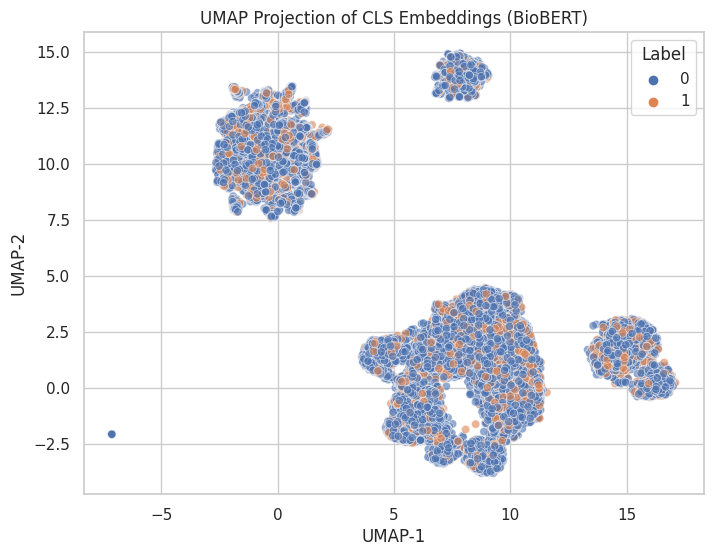

In [112]:
sns.set(style="whitegrid", context="notebook")
plt.figure(figsize=(8,6))
sns.scatterplot(x=umap_proj[:, 0], y=umap_proj[:, 1], hue=labels, palette="deep", alpha=0.6)
plt.title("UMAP Projection of CLS Embeddings (BioBERT)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Label")
plt.show()

In [113]:
sample_idx = 42

In [114]:
#input tensors
input_id_sample = input_ids_tensor[sample_idx].unsqueeze(0).to(device)
tabular_sample = tabular_features_tensor[sample_idx].unsqueeze(0).to(device)
label_sample = response_labels_tensor[sample_idx].item()

In [115]:
model.eval()
with torch.no_grad():
    output = model(input_id_sample, tabular_sample)
    prob = torch.sigmoid(output).item()

In [116]:
print(f"True Label: {label_sample}")
print(f"Predicted Probability: {prob:.4f}")

True Label: 0.0
Predicted Probability: 0.0015


In [117]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

In [118]:
# decode tokens
tokens = tokenizer.convert_ids_to_tokens(input_id_sample[0].cpu().numpy())
attention_mask = (input_id_sample != 0).long()

In [119]:
model.module.bio_bert.config.output_attentions = True


In [120]:
#attention outputs
with torch.no_grad():
    outputs = model.module.bio_bert(input_ids=input_id_sample, attention_mask=attention_mask)


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [121]:
#get attention from the last layer
last_layer_attention = outputs.attentions[-1]  
mean_attention = last_layer_attention.mean(dim=1)[0] 
cls_attention = mean_attention[0].cpu().numpy()

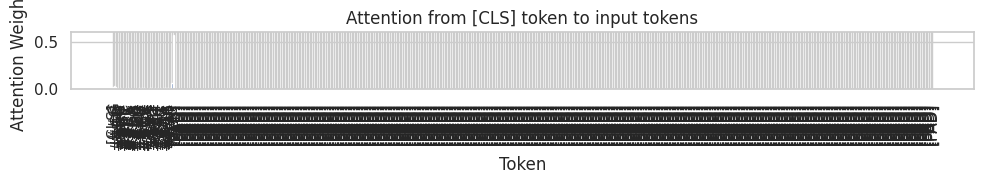

In [122]:
plt.figure(figsize=(10, 2))
plt.bar(range(len(tokens)), cls_attention)
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.title("Attention from [CLS] token to input tokens")
plt.xlabel("Token")
plt.ylabel("Attention Weight")
plt.tight_layout()
plt.show()

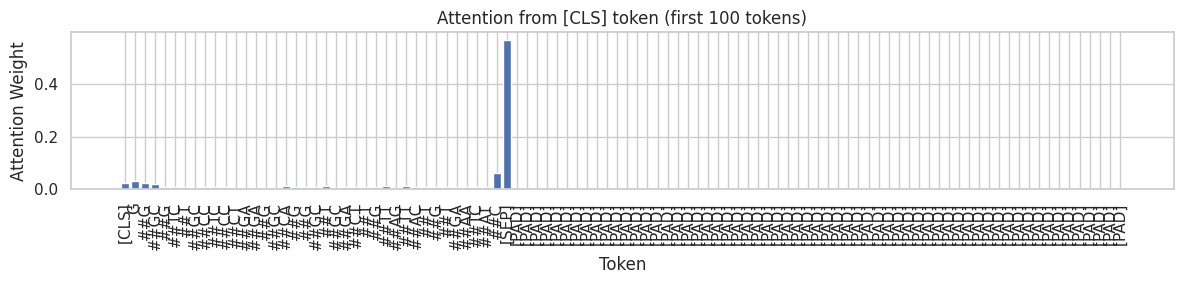

In [123]:
max_tokens = 100
plt.figure(figsize=(12, 3))
plt.bar(range(max_tokens), cls_attention[:max_tokens])
plt.xticks(range(max_tokens), tokens[:max_tokens], rotation=90)
plt.title("Attention from [CLS] token (first 100 tokens)")
plt.xlabel("Token")
plt.ylabel("Attention Weight")
plt.tight_layout()
plt.show()

In [124]:
top_idx = np.argsort(cls_attention)[-10:]  
top_tokens = [tokens[i] for i in top_idx]
top_weights = [cls_attention[i] for i in top_idx]

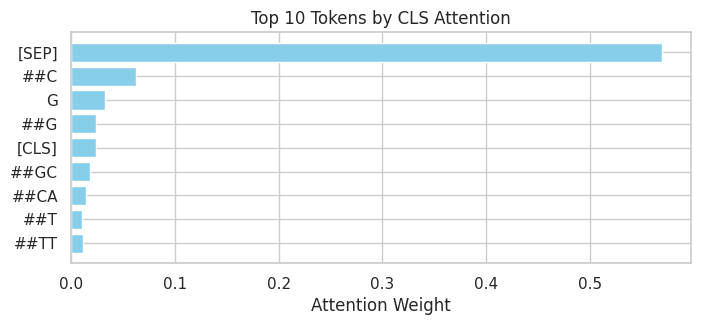

In [125]:
plt.figure(figsize=(8, 3))
plt.barh(top_tokens, top_weights, color="skyblue")
plt.xlabel("Attention Weight")
plt.title("Top 10 Tokens by CLS Attention")
plt.show()

In [126]:
from collections import Counter


In [127]:
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
attention_motifs = []

In [128]:
model.module.bio_bert.config.output_attentions = True
model.eval()

DataParallel(
  (module): MultimodalRNAInteractionModel(
    (bio_bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

In [132]:
!pip install logomaker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 62.4 MB/s eta 0:00:00:00:010:01


In [133]:
from collections import defaultdict

In [134]:
kmer_seqs = []
model.module.bio_bert.config.output_attentions = True

In [135]:
for idx in range(len(response_labels_tensor)):
    if response_labels_tensor[idx] != 1:
        continue

    input_ids = input_ids_tensor[idx].unsqueeze(0).to(device)
    attention_mask = (input_ids != 0).long()

    with torch.no_grad():
        outputs = model.module.bio_bert(input_ids=input_ids, attention_mask=attention_mask)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    cls_attention = outputs.attentions[-1].mean(dim=1)[0][0].cpu().numpy()

    top_indices = sorted(range(len(cls_attention)), key=lambda i: cls_attention[i], reverse=True)

    for i in top_indices:
        if tokens[i] in ['[CLS]', '[SEP]', '[PAD]'] or i < 3 or i > len(tokens)-3:
            continue

        kmer = tokens[i-3:i+3]
        kmer = ''.join([t.replace("##", "") for t in kmer])
        kmer_seqs.append(kmer.upper())
        break  

    if len(kmer_seqs) >= 200:  
        break

In [136]:
import logomaker

In [137]:
# Create frequency count matrix
position_counts = defaultdict(lambda: defaultdict(int))

In [138]:
for seq in kmer_seqs:
    for i, base in enumerate(seq):
        position_counts[i][base] += 1

In [139]:
df_logo = pd.DataFrame(position_counts).fillna(0).T
df_logo = df_logo / df_logo.sum(axis=1).values[:, None]

In [140]:
for base in ['A', 'C', 'G', 'T']:
    if base not in df_logo.columns:
        df_logo[base] = 0.0

In [141]:
df_logo = df_logo[['A', 'C', 'G', 'T']]  # reorder

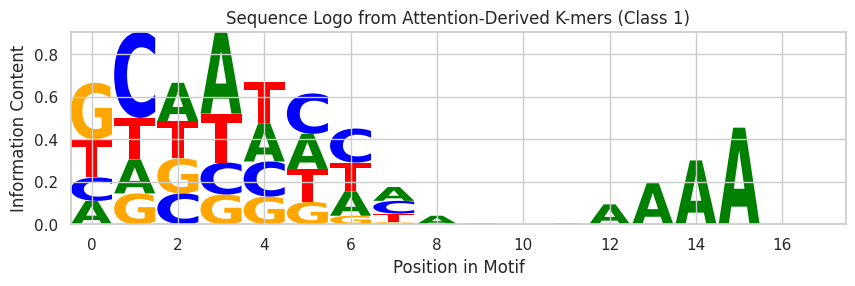

In [142]:
logomaker.Logo(df_logo, shade_below=.5, fade_below=.5, font_name='Arial Rounded MT Bold')
plt.title("Sequence Logo from Attention-Derived K-mers (Class 1)")
plt.xlabel("Position in Motif")
plt.ylabel("Information Content")
plt.show()

In [146]:
class TabularOnlyModel(nn.Module):
    def __init__(self, trained_model):
        super().__init__()
        self.tabular_net = trained_model.module.tabular_net if isinstance(trained_model, nn.DataParallel) else trained_model.tabular_net
        self.output = nn.Linear(128, 1)

    def forward(self, x):
        x = self.tabular_net(x)
        return self.output(x)


In [147]:
class BioBERTOnlyModel(nn.Module):
    def __init__(self, trained_model):
        super().__init__()
        self.bert = trained_model.module.bio_bert if isinstance(trained_model, nn.DataParallel) else trained_model.bio_bert
        self.output = nn.Linear(768, 1)

    def forward(self, input_ids):
        attention_mask = (input_ids != 0).long()
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = out.last_hidden_state[:, 0, :]  # CLS token
        return self.output(cls_embedding)


In [148]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

def evaluate_model(model, loader, mode="multimodal"):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for input_ids, tabular_data, labels in loader:
            input_ids = input_ids.to(device)
            tabular_data = tabular_data.to(device)
            labels = labels.to(device)

            if mode == "tabular":
                outputs = model(tabular_data)
            elif mode == "sequence":
                outputs = model(input_ids)
            else:
                outputs = model(input_ids, tabular_data)

            probs = torch.sigmoid(outputs).squeeze()
            preds = (probs > 0.5).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    f1 = f1_score(all_labels, all_preds)

    return acc, auc, f1


In [149]:
tab_model = TabularOnlyModel(model).to(device)
seq_model = BioBERTOnlyModel(model).to(device)

acc_tab, auc_tab, f1_tab = evaluate_model(tab_model, val_loader, mode="tabular")
acc_seq, auc_seq, f1_seq = evaluate_model(seq_model, val_loader, mode="sequence")
acc_mm, auc_mm, f1_mm = evaluate_model(model, val_loader, mode="multimodal")

In [150]:
models = ['Tabular-only', 'BioBERT-only', 'Multimodal']
accuracy = [acc_tab, acc_seq, acc_mm]
auc = [auc_tab, auc_seq, auc_mm]
f1 = [f1_tab, f1_seq, f1_mm]

x = np.arange(len(models))
width = 0.25

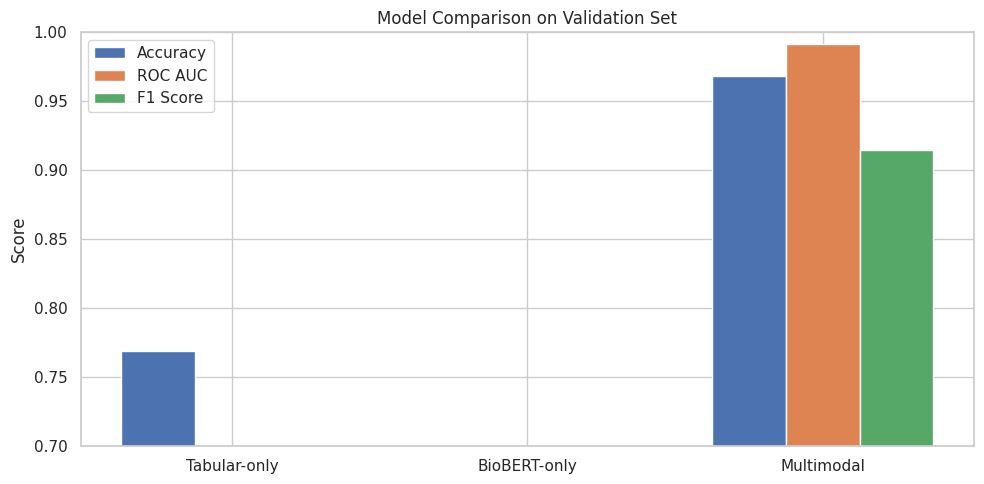

In [151]:
plt.figure(figsize=(10, 5))
plt.bar(x - width, accuracy, width, label='Accuracy')
plt.bar(x, auc, width, label='ROC AUC')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xticks(x, models)
plt.ylim(0.7, 1.0)
plt.title("Model Comparison on Validation Set")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

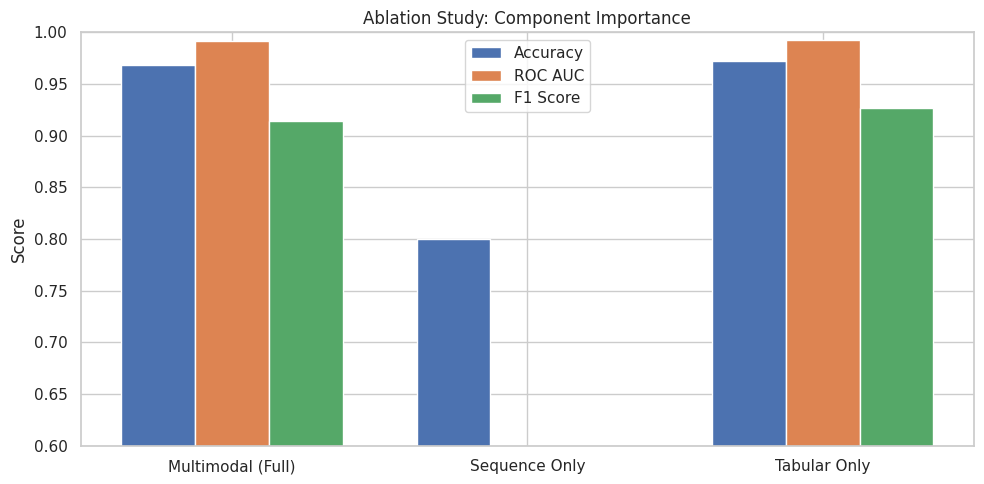

In [160]:
labels = ['Multimodal (Full)', 'Sequence Only', 'Tabular Only']
accuracy = [acc_full, acc_seq, acc_tab]
auc = [auc_full, auc_seq, auc_tab]
f1 = [f1_full, f1_seq, f1_tab]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 5))
plt.bar(x - width, accuracy, width, label='Accuracy')
plt.bar(x, auc, width, label='ROC AUC')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xticks(x, labels)
plt.ylim(0.6, 1.0)
plt.title("Ablation Study: Component Importance")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()
